In [64]:
from audioop import bias
import numpy as np
import cv2
from skimage.measure import label, regionprops
import copy
import os
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from skimage.measure import label, regionprops

In [65]:
folder  = 'data_scraping/data/'

_, _, color_data_files = next(os.walk(folder))
color_data_files.remove('.DS_Store')
color_data_files = sorted(color_data_files,key=lambda x: int(os.path.splitext(x)[0]))

# Load the first file first to initialize an array
with open(folder + color_data_files[0]) as file_name:

    # Initialize color data
    color_data = np.loadtxt(file_name, delimiter=",")

# Load the rest of the data
for ID, filename in enumerate(color_data_files):

    # Skip the first file since it is loaded
    if ID == 0:

        continue
        
    if ID == 6:
        break

    # Training images (Number of Pixels x Number of Features)
    with open(folder + filename) as file_name:
        
        new_data = np.loadtxt(file_name, delimiter=",")

    color_data = np.vstack((color_data, new_data))

In [66]:
# Sort the color label in an ascending order
idc = np.argsort(color_data[:, -1]) 
sorted_color_data = color_data[idc]
print(sorted_color_data[:-10,:])

[[  2.  48. 183. ...  94. 203.   1.]
 [  0.  44. 191. ...  94. 209.   1.]
 [  0.  43. 190. ...  94. 209.   1.]
 ...
 [130. 163. 196. ... 109. 150.  15.]
 [130. 163. 196. ... 109. 150.  15.]
 [131. 164. 197. ... 109. 150.  15.]]


In [67]:
# Data counts for each color class
unique, counts = np.unique(sorted_color_data[:,-1], return_counts=True)
dict(zip(unique, counts))

{1.0: 10514, 12.0: 6493, 14.0: 3266, 15.0: 17778}

In [68]:
# Unique pixel only
compressed_color_data = [tuple(row) for row in sorted_color_data]
compressed_color_data = np.unique(compressed_color_data, axis=0)
print(compressed_color_data.shape)

(6274, 13)


In [69]:
# Data counts for each color class
unique, counts = np.unique(compressed_color_data[:,-1], return_counts=True)
dict(zip(unique, counts))

{1.0: 1248, 12.0: 3522, 14.0: 508, 15.0: 996}

In [70]:
# Re-sort the array
idc = np.argsort(compressed_color_data[:, -1]) 
sorted_compressed_color_data = compressed_color_data[idc]
print(sorted_compressed_color_data)

[[  6.  73. 214. ...  83. 210.   1.]
 [  4.  66. 211. ...  85. 211.   1.]
 [  4.  66. 209. ...  85. 210.   1.]
 ...
 [ 98. 133. 173. ... 107. 154.  15.]
 [117. 147. 183. ... 110. 151.  15.]
 [123. 154. 185. ... 110. 149.  15.]]


In [78]:
### X_train and y_train
X_train = sorted_color_data[:, :-1]
y_train = sorted_color_data[:,-1]

### X_test
folder = "bin_detection/data/validation"
#folder = "bin_detection/data/training"
filename = '0067.jpg'
img = cv2.imread(os.path.join(folder,filename))
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img_RGB_norm = img_RGB.astype(np.float64)/255
img_HSV_norm = img_HSV.astype(np.float64)/255
img_LAB_norm = img_LAB.astype(np.float64)/255
img_YCrCb_norm = img_YCrCb.astype(np.float64)/255

img_height, img_width, _ = img.shape

# Initialize a mask
mask_img = np.zeros((img_height,img_width), np.uint8) # Black Pixel = 0, White Pixel = 1

# Reshape the image from H x W x 3 to (H X W) X 3
img_RGB_norm = img_RGB_norm.reshape(img_RGB_norm.shape[0]*img_RGB_norm.shape[1],img_RGB_norm.shape[2])
img_HSV_norm = img_HSV_norm.reshape(img_HSV_norm.shape[0]*img_HSV_norm.shape[1],img_HSV_norm.shape[2])
img_LAB_norm = img_LAB_norm.reshape(img_LAB_norm.shape[0]*img_LAB_norm.shape[1],img_LAB_norm.shape[2])
img_YCrCb_norm = img_YCrCb_norm.reshape(img_YCrCb_norm.shape[0]*img_YCrCb_norm.shape[1],img_YCrCb_norm.shape[2])

# Compile the dataset as X_test (N x 12 features)
X_test = np.concatenate((img_RGB_norm, img_HSV_norm, img_LAB_norm, img_YCrCb_norm), axis = 1)
#X_test = img_RGB_norm
#X_test = np.concatenate((img_RGB_norm, img_HSV_norm), axis = 1)

In [79]:
def one_VS_ALL_LogReg(X_train, y_train, X, lr = 0.1, max_iters = 5000, err_tol = 1e-3, bias = 1):
    
    # Define sigmoid function
    def sigmoid(func_x):
        return 1 / (1 + np.exp(-func_x))

    # Add bias term
    X_train = np.insert(X_train, 0, bias, axis = 1)

    # Train
    # Number of samples and features
    num_Samples, num_Features = X_train.shape

    # List that stores the weights
    weights = []

    # Array that stores every iteration of loss
    loss_arry = np.zeros(max_iters)
    
    # Different Color Classes
    color_class = np.unique(y_train)

    # One vs ALL Binary Classification
    for color in color_class:

        # Binary label whether is the current color or not. (1 is the color, 0 is not)
        binary_label = np.where(y_train == color, 1, 0)

        # Initialize the weight
        weight = np.zeros(num_Features)

        for idx in range(0, max_iters):

            # Determine Probability
            y_predicted = sigmoid(np.dot(X_train, weight))

            # Cross Entropy Loss function
            loss_arry[idx] = 1 / num_Samples * np.sum(-binary_label * np.log(y_predicted) * np.log(1 - y_predicted))

            # Gradient Descend function
            grad_desc = 1 / num_Samples * (np.dot((binary_label - y_predicted), X_train))

            # Store previous weight
            prev_weight = copy.deepcopy(weight)

            # Update weight
            weight += lr * grad_desc

            # If less than the error tolerance, break the loop to prevent overtraining/overfitting (early stopping)
            if np.linalg.norm(prev_weight - weight) < err_tol:
                break

        # Append the trained weight
        weights.append(weight)
        
    print(weights)

    # Add bias term
    X_test = np.insert(X, 0, bias, axis = 1)

    # Predicted label
    y_predicted = [np.argmax([sigmoid(np.dot(x_test, weight)) for weight in weights]) for x_test in X_test]

    # Predict the outcome
    y = np.rint(np.array([color_class[color] for color in y_predicted]))
    
    return y

print(X_test.shape, X_train.shape, y_train.shape)

y_predict = one_VS_ALL_LogReg(X_train, y_train, X_test, lr = 0.1, max_iters = 5000, err_tol = 1e-3, bias = 1)

(1328338, 12) (38051, 12) (38051,)


/Users/kaitheuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/kaitheuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/Users/kaitheuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


[array([ -0.0356813 ,  -9.22751274,  -6.75686698,   7.78064151,
        -0.11059022,   6.49368513,   5.43087308,  -4.39806456,
         0.60314113, -12.09164392,  -5.84650138,  -6.99441   ,
         3.11712916]), array([ 3.84581535e-03,  2.63773987e+00,  5.77359467e+00, -1.00396181e+01,
       -4.59486166e+00,  4.49659603e+00, -2.13225103e+00,  3.95830549e+00,
       -4.96569968e+00,  8.50421667e+00,  3.02654883e+00,  2.09753997e-01,
       -6.89575385e+00]), array([ 0.01010631,  1.12571405, -2.59338792, -0.17900986,  3.32512964,
       -5.37405822, -2.85897579, -2.21201353,  2.76821721,  0.17751123,
       -1.18360195,  2.97470124,  1.88253437]), array([ -0.03832304,   9.30501004,  -0.68463526,  17.95919346,
        22.64897308,  -1.10390407, -12.75129632,  -4.25016015,
       -17.64312805, -18.30170296,   4.34483157,  -1.39027227,
         2.89745888])]


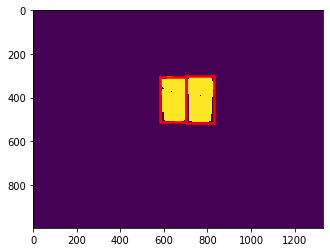

In [80]:
# Get the image dimension
img_height, img_width, _ = img.shape

# Initialize a mask
mask_img = np.zeros((img_height,img_width), np.uint8) # Black Pixel = 0, White Pixel = 1

y_predict_2D = y_predict.reshape(img_height, img_width) # Height x Width

# Unmask the pixel that is a recycling-bin-blue
for height in range(img_height):
    for width in range(img_width):
        if y_predict_2D[height, width] == 1:
            mask_img[height, width] = 1 # Recycling-Blue-Bin is a white pixel

fig = plt.figure() 
            
kernel_errosion_shape = 3
kernel_dilation_shape = 8
kernel_errosion = np.ones((kernel_errosion_shape, kernel_errosion_shape), np.uint8)
kernel_dilation = np.ones((kernel_dilation_shape, kernel_dilation_shape), np.uint8)

# Erode to filter out noise
mask_img = cv2.erode(mask_img, kernel_errosion, iterations = 3)
# Dilate to regain the size of the recycle bin without noise
mask_img = cv2.dilate(mask_img, kernel_dilation, iterations = 2)

# Labeled array, where all connected regions are assigned the same integer value.
label_img = label(mask_img)

# Return  list of RegionProperties from the label_img
regions = regionprops(label_img)

# Initialize the box list
boxes = []

# Regions props
for props in regions:

    # Make sure the the size of the recycling bin blue is appropriate[0.55, 0.008]
    if  0.55 * mask_img.shape[0] * mask_img.shape[1] > props.area > 0.006 * mask_img.shape[0] * mask_img.shape[1]:

        # Get the bounding box top left and bottom right coordinates
        minr, minc, maxr, maxc = props.bbox

        # Calculate the height and width of the bounding box
        bb_height, bb_width = maxr - minr, maxc - minc

        # Check if the hight-to-width ratio of the recycling-bin-blue makes sense. [1.0, 2.55]
        if bb_width * 1.0 < bb_height < bb_width * 2.55:

            # X-coordinates
            bx = (minc, maxc, maxc, minc, minc)
            # Y-coordinates
            by = (minr, minr, maxr, maxr, minr)
            # Draw bounding box
                  
            plt.plot(bx, by, '-r', linewidth=2.5)
            # Add to boxes list
            boxes.append([minc, minr, maxc, maxr])
            
plt.imshow(mask_img)
plt.show()

In [74]:
print(sorted_color_data.shape)

(38051, 13)


In [63]:
print(sorted_color_data)

[[  2.  48. 183. ...  94. 203.   1.]
 [  0.  44. 191. ...  94. 209.   1.]
 [  0.  43. 190. ...  94. 209.   1.]
 ...
 [128. 161. 196. ... 109. 151.  15.]
 [130. 163. 196. ... 109. 150.  15.]
 [100. 138. 177. ... 106. 154.  15.]]
